<a href="https://colab.research.google.com/github/Bibhash123/Project-Primary-Quantization/blob/main/experiments/Primary_Quantization_Preliminary_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle datasets download -d "bibhash123/tondidataset"
!unzip -q tondidataset.zip -d "/content/Data/"
!rm -r tondidataset.zip

Saving kaggle.json to kaggle.json
 97% 562M/581M [00:17<00:00, 47.2MB/s]
100% 581M/581M [00:17<00:00, 34.6MB/s]


In [ ]:
import os
import gc
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [ ]:
def seedAll(seed):
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)

seedAll(42)

In [ ]:
train_files = pd.read_csv("/content/Data/train.csv",sep=";",header=None,
                         names=['idx', 'filenames', 'quality1', 'quality2', 'software', 'labels',
                                'shift_r', 'shift_c']
                         )

trn,val = train_test_split(train_files,test_size=0.1)

In [ ]:
def preprocess_input(im_file, target_size, scale=255.):
    """ 
        Read image and (eventually) scale data
        Arguments:
            im_file     : input image file
            target_size : output size of the image (height, width)
            scale       : pixel scaling value
        Returns: The image
    """
    file_bytes = tf.io.read_file(im_file)
    img = tf.image.decode_png(file_bytes, channels = 0)
    # Normalize and Resize
    if img.shape != target_size:
        img = tf.image.resize(img, target_size)
    img = tf.cast(img/scale, tf.float32)
    return img
  
def string2Q(s, size=(8, 8), flatten=True):
    """ Converts a comma separated string to a matrix.
        Keyword arguments:
        sq : input string
        size : output matrix size
    """
    if flatten:
        return tf.strings.to_number(tf.strings.split(s,','),out_type=tf.int32)
    else:
        return tf.reshape(tf.strings.to_number(tf.strings.split(s,','),out_type=tf.int32),size)
        
def get_label(im_label):
    return string2Q(im_label)[:15]

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_decoder(is_labelled):
  def if_labelled(path,label,target_size):
    image = preprocess_input(path,target_size)
    label = get_label(label)
    return image,label
  
  return if_labelled if is_labelled else preprocess_input

def create_dataset(df, batch_size = 32, is_labelled = False, repeat = False, shuffle = False, batch=False, cache=False):
    decode_fn = build_decoder(is_labelled)
    
    # Create Dataset
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((df['filenames'].values,df["labels"].values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((df['filenames'].values))

    dataset = dataset.map(partial(decode_fn,target_size=(64,64)), num_parallel_calls = AUTOTUNE)
    dataset = dataset.cache("") if cache else dataset
    dataset = dataset.repeat() if repeat else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset
    dataset = dataset.batch(batch_size,drop_remainder=True) if batch else dataset
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def getX(X,Y):
  return X
def getY(X,Y):
  return Y

# Constrained Convolution Network

In [ ]:
class ConvConst(tf.keras.models.Model):
  def __init__(self,nc=15):
    super(ConvConst,self).__init__()
    self.nc = nc
    self.block1 = L.Conv2D(12,(5,5),strides=1,input_shape=(None,64,64,1))
    
    self.block2 = tf.keras.models.Sequential([
                                              L.Conv2D(96,(7,7),strides=2),
                                              L.BatchNormalization(),
                                              L.Activation('tanh'),
                                              L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    self.block3 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization()
    ])
    self.block4 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.AveragePooling2D(pool_size=(3,3),strides=2)
    ])

    self.fc1 = L.Dense(200)
    self.fc2 = L.Dense(200)
    self.fc3 = L.Dense(nc,activation="linear")

  def call(self,inputs,**kwargs):
    out = self.block1(inputs)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)

    out = L.Flatten()(out)

    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
class ConstWeight(tf.keras.callbacks.Callback):
  def on_batch_end(self,epoch,logs={}):
    weights = self.model.layers[0].get_weights()
    weights[0][2,2,0,:] = np.zeros((12,))
    for i in range(weights[0].shape[-1]):
      t = weights[0][:,:,0,i]
      nom = -1*np.sum(t)
      weights[0][:,:,:,i] = weights[0][:,:,:,i]/nom
    weights[0][2,2,0,:] = np.ones((12,))  
    self.model.layers[0].set_weights(weights)

In [ ]:
train_set = create_dataset(trn, batch_size = 64, is_labelled = True, repeat = True, 
                          shuffle = True, batch=True,cache=True)
val_set = create_dataset(val, batch_size = 64, is_labelled = True, repeat = False, 
                          shuffle = False, batch=True,cache=True)
Y_val = val_set.map(getY)

In [ ]:
K.clear_session()
model = ConvConst(nc=15)
model.build((None,64,64,1))
model.compile(loss=tf.keras.losses.LogCosh(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "conv_const"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  312       
                                                                 
 sequential (Sequential)     (None, 13, 13, 96)        56928     
                                                                 
 sequential_1 (Sequential)   (None, 9, 9, 64)          153920    
                                                                 
 sequential_2 (Sequential)   (None, 2, 2, 64)          102720    
                                                                 
 dense (Dense)               multiple                  51400     
                                                                 
 dense_1 (Dense)             multiple                  40200     
                                                                 
 dense_2 (Dense)             multiple                  3

In [ ]:
ckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5', monitor = 'val_loss', mode='min',
                                          save_best_only = True, save_weights_only = True)
const = ConstWeight()
es = tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_loss', mode='min',
                                      restore_best_weights=True)

model.fit(
          train_set,
          epochs = 100,
          steps_per_epoch = (trn.shape[0]//64),
          validation_data = val_set,
          callbacks = [ckpt,const,es]
          )

pred = model.predict(val_set)

Epoch 1/100
3037/3037 [==============================] - 107s 35ms/step - loss: 2.4112 - val_loss: 2.1100
Epoch 2/100
3037/3037 [==============================] - 106s 35ms/step - loss: 1.9876 - val_loss: 3.3712
Epoch 3/100
3037/3037 [==============================] - 106s 35ms/step - loss: 1.8207 - val_loss: 1.9768
Epoch 4/100
3037/3037 [==============================] - 105s 35ms/step - loss: 1.7180 - val_loss: 2.2732
Epoch 5/100
3037/3037 [==============================] - 106s 35ms/step - loss: 1.6443 - val_loss: 1.7004
Epoch 6/100
3037/3037 [==============================] - 106s 35ms/step - loss: 1.6023 - val_loss: 2.3808
Epoch 7/100
3037/3037 [==============================] - 105s 35ms/step - loss: 1.5723 - val_loss: 1.9637
Epoch 8/100
3037/3037 [==============================] - 105s 34ms/step - loss: 1.5264 - val_loss: 1.6892
Epoch 9/100
3037/3037 [==============================] - 105s 34ms/step - loss: 1.4886 - val_loss: 1.4635
Epoch 10/100
3037/3037 [======================

In [ ]:
y = np.array(list(Y_val.unbatch().as_numpy_iterator()))
y.shape

(21568, 15)

In [ ]:
print("Accuracy = {:.4f}".format(np.count_nonzero(np.round(pred)==y)/(15*y.shape[0])))
print("RMSE = {:.4f}".format(np.sum(np.square(y - pred)) / (y.shape[0]*15)))

Accuracy = 0.2303
RMSE = 5.1007


In [ ]:
!python predict.py --model "/content/model.hdf5" --test_csv "/content/Data/test.csv" --rslt_dir "/content/results/" --max_q_coeffs 15

2021-12-11 07:51:49.432806: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Found 6000 images and 6000 labels in /content/Data/test.csv with filter (60, 90)
Estimating Quantization Matrix: 100% 6000/6000 [05:27<00:00, 18.35it/s]
--------------------------------------------------------------------------------
QF1 = 60 QF2 = 90
--------------------------------------------------------------------------------
Test average MSE: 7.7639
Test average normalised MSE: 0.0513
Test accuracy: 0.1214
--------------------------------------------------------------------------------


Found 6000 images and 6000 labels in /content/Data/test.csv with filter (65, 90)
Estimating Quantization Matrix: 100% 6000/6000 [05:30<00:00, 18.17it/s]
--------------------------------------------------------------------------------
QF1 = 65 QF2 = 90
-------------------------------

In [ ]:
pd.read_csv("/content/results/final_results.csv")

,QFs,nmse,mse,accuracy
0,"60,90",0.051268,7.763879,0.121411
1,"65,90",0.034760,4.125769,0.233178
2,"70,90",0.032717,2.796231,0.258944
3,"75,90",0.044915,2.780631,0.271056
4,"80,90",0.101915,3.788544,0.197022
5,"85,90",0.204398,4.348971,0.206156
6,"90,90",0.544114,4.802990,0.212378
7,"95,90",2.880537,5.251622,0.339289
8,"98,90",5.734883,5.734883,0.351489


Text(0.5, 1.0, 'Accuracy vs QF pair')

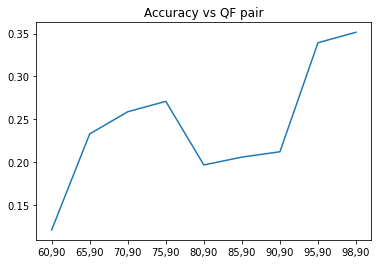

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
rslt = pd.read_csv("/content/results/final_results.csv")
plt.plot(rslt['QFs'].values,rslt['accuracy'].values)
plt.title("Accuracy vs QF pair")

Text(0.5, 1.0, 'Accuracy vs QF pair')

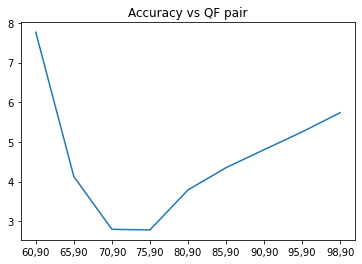

In [ ]:
plt.plot(rslt['QFs'].values,rslt['mse'].values)
plt.title("Accuracy vs QF pair")

# Simple Convolution Network

In [ ]:
class ConvConst(tf.keras.models.Model):
  def __init__(self,nc=15):
    super(ConvConst,self).__init__()
    self.nc = nc
    
    self.block1 = tf.keras.models.Sequential([
                                              L.Conv2D(96,(7,7),strides=2),
                                              L.BatchNormalization(),
                                              L.Activation('relu'),
                                              L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    self.block2 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization()
    ])
    self.block3 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('relu'),
                                             L.AveragePooling2D(pool_size=(3,3),strides=2)
    ])

    self.fc1 = L.Dense(200)
    self.fc2 = L.Dense(200)
    self.fc3 = L.Dense(nc,activation="linear")

  def call(self,inputs,**kwargs):
    out = self.block1(inputs)
    out = self.block2(out)
    out = self.block3(out)
    out = L.Flatten()(out)

    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
train_set = create_dataset(trn, batch_size = 64, is_labelled = True, repeat = True, 
                          shuffle = True, batch=True,cache=True)
val_set = create_dataset(val, batch_size = 64, is_labelled = True, repeat = False, 
                          shuffle = False, batch=True,cache=True)
Y_val = val_set.map(getY)

In [ ]:
K.clear_session()
model = ConvConst(nc=15)
model.build((None,64,64,1))
model.compile(loss=tf.keras.losses.LogCosh(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "conv_const"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 14, 14, 96)        5184      
                                                                 
 sequential_1 (Sequential)   (None, 10, 10, 64)        153920    
                                                                 
 sequential_2 (Sequential)   (None, 2, 2, 64)          102720    
                                                                 
 dense (Dense)               multiple                  51400     
                                                                 
 dense_1 (Dense)             multiple                  40200     
                                                                 
 dense_2 (Dense)             multiple                  3015      
                                                                 
Total params: 356,439
Trainable params: 355,991
Non-trai

In [ ]:
ckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5', monitor = 'val_loss', mode='min',
                                          save_best_only = True, save_weights_only = True)
es = tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_loss', mode='min',
                                      restore_best_weights=True)

model.fit(
          train_set,
          epochs = 100,
          steps_per_epoch = (trn.shape[0]//64),
          validation_data = val_set,
          callbacks = [ckpt,es]
          )

pred = model.predict(val_set)

Epoch 1/100
3037/3037 [==============================] - 143s 43ms/step - loss: 2.6657 - val_loss: 2.7398
Epoch 2/100
3037/3037 [==============================] - 50s 17ms/step - loss: 2.5409 - val_loss: 3.9379
Epoch 3/100
3037/3037 [==============================] - 50s 16ms/step - loss: 2.4812 - val_loss: 2.6512
Epoch 4/100
3037/3037 [==============================] - 50s 16ms/step - loss: 2.4374 - val_loss: 2.7201
Epoch 5/100
3037/3037 [==============================] - 49s 16ms/step - loss: 2.4111 - val_loss: 3.5026
Epoch 6/100
3037/3037 [==============================] - 50s 16ms/step - loss: 2.3679 - val_loss: 3.1510
Epoch 7/100
3037/3037 [==============================] - 52s 17ms/step - loss: 2.3362 - val_loss: 3.9017
Epoch 8/100
3037/3037 [==============================] - 50s 16ms/step - loss: 2.3143 - val_loss: 21.9314
Epoch 9/100
3037/3037 [==============================] - 52s 17ms/step - loss: 2.2879 - val_loss: 6.6134
Epoch 10/100
3037/3037 [=============================

In [ ]:
y = np.array(list(Y_val.unbatch().as_numpy_iterator()))
y.shape

(21568, 15)

In [ ]:
print("Accuracy = {:.4f}".format(np.count_nonzero(np.round(pred)==y)/(15*y.shape[0])))
print("RMSE = {:.4f}".format(np.sum(np.square(y - pred)) / (y.shape[0]*15)))

Accuracy = 0.0816
RMSE = 16.4782


In [ ]:
!python predict.py --const 0 --model "/content/model.hdf5" --test_csv "/content/Data/test.csv" --rslt_dir "/content/results/" --max_q_coeffs 15

2021-12-11 14:28:00.512219: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Found 6000 images and 6000 labels in /content/Data/test.csv with filter (60, 90)
Estimating Quantization Matrix: 100% 6000/6000 [05:27<00:00, 18.30it/s]
--------------------------------------------------------------------------------
QF1 = 60 QF2 = 90
--------------------------------------------------------------------------------
Test average MSE: 100.9731
Test average normalised MSE: 0.6587
Test accuracy: 0.0000
--------------------------------------------------------------------------------


Found 6000 images and 6000 labels in /content/Data/test.csv with filter (65, 90)
Estimating Quantization Matrix: 100% 6000/6000 [05:33<00:00, 17.99it/s]
--------------------------------------------------------------------------------
QF1 = 65 QF2 = 90
-----------------------------